In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import cv2
import torch
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid

In [2]:
#!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [3]:
#!pip install openmim
#!mim install mmdet
#!git clone https://github.com/open-mmlab/mmdetection.git
#%cd mmdetection
#!pip install -q -e .
#!wget https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

In [4]:
#%%bash
#export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/opt/conda/lib/python3.7/site-packages/torch/lib/

In [5]:
#df = pd.read_csv('../exps/exp1_swin_large_patch4_window12_384/train_cv_score.csv')
df = pd.read_csv('ens.csv')

<AxesSubplot:>

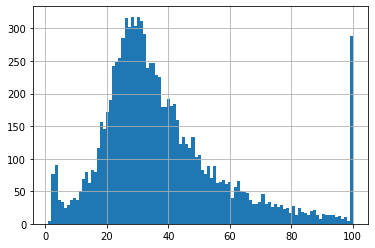

In [6]:
df['Pawpularity'].hist(bins=100)

<AxesSubplot:>

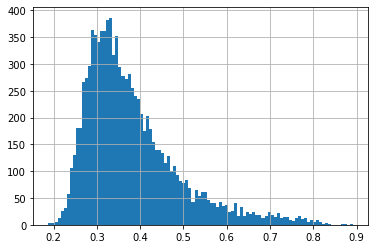

In [7]:
df['pred'].hist(bins=100)

In [8]:
np.sqrt((((df['pred']).clip(0.1, 1) - df['norm_score']) ** 2).mean()) * 100

17.195171665188735

In [9]:
np.sqrt((((df['pred'] / df['pred'].mean() * df['norm_score'].mean()).clip(0.1, 1) - df['norm_score']) ** 2).mean()) * 100

17.195560888672

In [10]:
np.sqrt(((np.where(df['pred'] > 0.8, 1, df['pred']) - df['norm_score']) ** 2).mean()) * 100

17.231647296731634

In [11]:
df['Pawpularity'].value_counts().sort_index(ascending=False)#.cumsum()# / df.shape[0]

100    288
99       4
98      10
97       8
96      12
      ... 
5       34
4       36
3       90
2       77
1        4
Name: Pawpularity, Length: 100, dtype: int64

In [12]:
pred = (df['pred'] - df['pred'].mean()) / df['pred'].std()
pred = pred * df['norm_score'].std() + df['norm_score'].mean()
pred = pred.clip(0.1, 1)
np.sqrt(((pred - df['norm_score']) ** 2).mean()) * 100

19.21532875802139

In [13]:
df['norm_score'].mean()

0.3803904358353526

In [14]:
np.sqrt((((df['pred'] - df['pred'].mean() + df['norm_score'].mean()).clip(0.1, 1) - df['norm_score']) ** 2).mean()) * 100

17.194812044268282

In [15]:
sc = np.sort(df['pred'])[::-1]
pred = np.zeros(df.shape[0])
s = 0
for i, v in df['Pawpularity'].value_counts().sort_index(ascending=False).to_frame('cnt').iterrows():
    s += v['cnt'] - 1    
    pred[(df['pred'] > sc[s]) & (pred == 0)] = i / 100


In [16]:
np.sqrt(((pred - df['norm_score']) ** 2).mean()) * 100

19.65176553442115

In [17]:
'''
from mmdet.apis import init_detector, inference_detector
import mmcv

path = df.loc[0, 'path']

# Specify the path to model config and checkpoint file
config_file = 'mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# test a single image and show the results
img = path  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)
# visualize the results in a new window
#plt.imshow(model.show_result(img, result))
# or save the visualization results to image files
#model.show_result(img, result, out_file='result.jpg')
'''
pass

In [18]:
COCO_LABELS = {
 #1: 'person',
 #2: 'bicycle',
 #3: 'car',
 #4: 'motorcycle',
 #5: 'airplane',
 #6: 'bus',
 #7: 'train',
 #8: 'truck',
 #9: 'boat',
 #10: 'traffic light',
 #11: 'fire hydrant',
 #12: 'stop sign',
 #13: 'parking meter',
 #14: 'bench',
 15: 'bird',
 16: 'cat',
 17: 'dog',
 18: 'horse',
 19: 'sheep',
 20: 'cow',
 21: 'elephant',
 22: 'bear',
 23: 'zebra',
 24: 'giraffe',
 #25: 'backpack',
 #26: 'umbrella',
 #27: 'handbag',
 #28: 'tie',
 #29: 'suitcase',
 #30: 'frisbee',
 #31: 'skis',
 #32: 'snowboard',
 #33: 'sports ball',
 #34: 'kite',
 #35: 'baseball bat',
 #36: 'baseball glove',
 #37: 'skateboard',
 #38: 'surfboard',
 #39: 'tennis racket',
 #40: 'bottle',
 #41: 'wine glass',
 #42: 'cup',
 #43: 'fork',
 #44: 'knife',
 #45: 'spoon',
 #46: 'bowl',
 #47: 'banana',
 #48: 'apple',
 #49: 'sandwich',
 #50: 'orange',
 #51: 'broccoli',
 #52: 'carrot',
 #53: 'hot dog',
 #54: 'pizza',
 #55: 'donut',
 #56: 'cake',
 #57: 'chair',
 #58: 'couch',
 #59: 'potted plant',
 #60: 'bed',
 #61: 'dining table',
 #62: 'toilet',
 #63: 'tv',
 #64: 'laptop',
 #65: 'mouse',
 #66: 'remote',
 #67: 'keyboard',
 #68: 'cell phone',
 #69: 'microwave',
 #70: 'oven',
 #71: 'toaster',
 #72: 'sink',
 #73: 'refrigerator',
 #74: 'book',
 #75: 'clock',
 #76: 'vase',
 #77: 'scissors',
 #78: 'teddy bear',
 #79: 'hair drier',
 #80: 'toothbrush'
}

In [19]:
def get_det_result(result):
    for i, label in COCO_LABELS.items():
        for res in result[i - 1]:
            if res[4] > 0.3:
                return [i] + res.tolist()
    return [np.nan] * 6

In [20]:
df[df.norm_score == 0.01].path

1450    ../input/petfinder-pawpularity-score/train/6c1...
1753    ../input/petfinder-pawpularity-score/train/e0a...
2964    ../input/petfinder-pawpularity-score/train/3ed...
4846    ../input/petfinder-pawpularity-score/train/53b...
Name: path, dtype: object

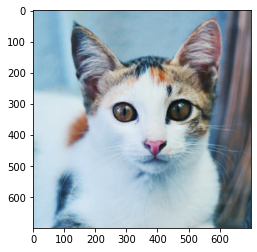

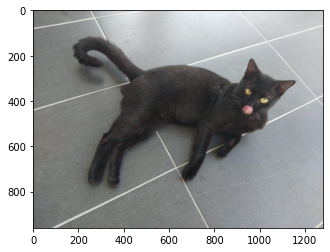

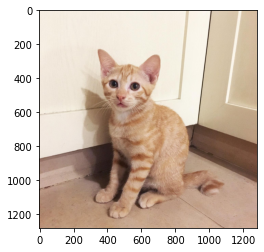

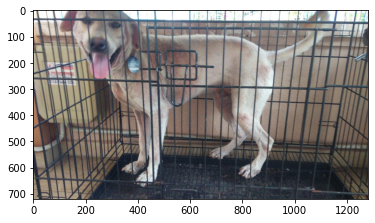

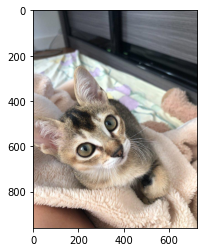

In [21]:
for path in df[df.norm_score == 0.3].path.values[:5]:
    image = cv2.imread(path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [22]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

In [23]:
model = timm.create_model('resnet200d')

In [24]:
if 0:
    device = 'cpu'
    model.to(device)
    with torch.no_grad():
        list_label = []
        list_det = []
        for path in tqdm(df['path'].values):

            #result = inference_detector(model, path)
            #list_det.append(get_det_result(result))
            image = cv2.imread(path)
            list_label.append(image.shape)

            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255

            #image = cv2.resize(image, (240, 240))
            #image = np.moveaxis(image, -1, 0)
            #image = torch.tensor([image], dtype=torch.float32, device=device)
            #list_label.append(model(image).cpu().numpy()[0].argmax())

    #df['resnet_label'] = list_label
    list_label = np.array(list_label)
    df['img_h'] = list_label[:, 0]
    df['img_w'] = list_label[:, 1]
    #list_det = np.stack([d if len(d) == 6 else [np.nan] * 6 for d in list_det])

    #df['det_label'] = list_det[:, 0]
    #df['det_left'] = list_det[:, 1]
    #df['det_top'] = list_det[:, 2]
    #df['det_right'] = list_det[:, 3]
    #df['det_bottom'] = list_det[:, 4]
    #df['det_prob'] = list_det[:, 5]


In [25]:
COL_FEATURES = ['Blur', 'Face', 'Occlusion', 'Eyes', 'Accessory',
               'Group', 'Human', 'Near', 'Collage', 'Info', 'Action',
                'pred'
               ]
#COL_FEATURES = COL_FEATURES[:7]

In [26]:
df[COL_FEATURES]

,Blur,Face,Occlusion,Eyes,Accessory,Group,Human,Near,Collage,Info,Action,pred
0,1,1,0,0,0,0,0,1,0,0,0,0.354970
1,0,1,0,1,1,0,0,1,1,1,0,0.398450
2,0,1,0,0,1,0,0,1,0,0,0,0.335640
3,0,1,1,1,0,0,1,1,0,0,0,0.243858
4,0,1,0,1,0,0,0,1,1,0,0,0.310697
...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,1,0,1,0,0,0,1,0,0,0,0.455137
9908,0,1,0,1,0,0,0,1,0,0,0,0.518121
9909,0,1,1,1,0,0,1,0,0,0,0,0.324151
9910,0,1,0,1,0,0,0,1,0,0,0,0.377962


In [27]:
np.sqrt(((df['Pawpularity'] / 100 - df['pred'].values) ** 2).mean())

0.17195171665188735

In [28]:
def rmse(preds, train_data):
    labels = train_data.get_label()
    loss = np.sqrt(((labels - preds.clip(0.01, 1)) ** 2).mean()) * 100
    return 'rmse', loss, False

from sklearn.svm import SVR
def train(fold, param):
     
    X_train = df.loc[df['fold'] != fold, COL_FEATURES]
    y_train = df.loc[df['fold'] != fold, 'Pawpularity'].values / 100
    
    X_valid = df.loc[df['fold'] == fold, COL_FEATURES]
    y_valid = df.loc[df['fold'] == fold, 'Pawpularity'].values / 100
    
    model = SVR(C=20)
    model.fit(X_train.values, y_train)
    
    sc = np.sqrt(((model.predict(X_valid.values) - y_valid) ** 2).mean())
    #sc = np.sqrt(((X_valid['pred'].values - y_valid) ** 2).mean())
    return sc

In [29]:
all_params = {'objective': ['xentropy'],
             'verbosity': [-1],
             'boosting_type': ['gbdt'],
             # 'feature_pre_filter': False,
             # 'bagging_fraction': 1.0,
             'bagging_freq': [1],
             'num_iterations': [10000],
             'early_stopping_round': [10],
             'n_jobs': [16],
             'seed': [114],
             'metric':  ['None'],  # trial.suggest_categorical('metric', ['auc', 'binary_logloss', ]), #'auc',
             'learning_rate': [0.1],
              'lambda_l1': [0],
              'lambda_l2': [0],
              'min_child_samples': [15],
              'num_leaves': [3],
              'feature_fraction': [0.8],
              'min_gain_to_split': [0]
             #'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 10),
             #'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 10),
             # 'num_leaves': trial.suggest_int('num_leaves', 7, 127),
             # 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1),
             # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 500),
             # 'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1),
             # 'feature_fraction_bynode': trial.suggest_uniform('feature_fraction_bynode', 0.5, 1),
             # 'min_gain_to_split': trial.suggest_uniform('min_gain_to_split', 0, 10),
             }

In [30]:
best_score = 1.0e10
best_param = None
if 1:
    list_loss = []
    list_imp = []
    for fold in range(5):
        sc = train(fold, None)
        #sc = model.best_score['valid_0']['rmse']# * 100
        list_loss.append(sc)
        print(fold, sc)
        
    sc = np.mean(list_loss)
    if sc < best_score:
        best_score = sc
    

0 0.17494719789212057
1 0.1753468562352651
2 0.17606717595766833
3 0.1786999812047461
4 0.17383830479545578


In [31]:
print(best_score)

0.17577990321705117


In [32]:
with open('models/model_lgb_1215.pkl', 'wb') as f:
    pickle.dump(model, f, -1)

In [33]:
#imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
#imp['col'] = COL_FEATURES
imp = sum(list_imp) / 5
imp.sort_values('imp', ascending=False)

AttributeError: 'float' object has no attribute 'sort_values'